In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from f110_gym.envs.base_classes import Integrator
import random
import os
import pandas as pd
import time
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import sys
from f110_gym.envs.f110_env import F110Env
from matplotlib.colors import LinearSegmentedColormap
import yaml
from PIL import Image
import json
import seaborn as sns

In [2]:
class Reward:
    def __init__(self, min_speed=0.8, max_speed=2, map_centers=None,track_width = 2.2):
        # Keep existing parameters
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.set_parameters(map_centers,track_width)
        
        # Hyperparameters
        self.epsilon = 1e-5
        self.distance_travelled = 0
        self.milestone = 0
        self.subtract_distance = 0
        
    def set_parameters(self,map_centers, track_width):
        '''
        Helper function to set the parameters of the reward function externally from the class instance
        Args:
            map_centers (np.ndarray): Array of map centers.
            track_width (float): Width of the track.
        '''
        self.map_centers = map_centers
        # Initial point and center that determines the position at the start of episode
        self.initial_point = np.array([[0, 0]])
        self.initial_center_idx , _ = self.__calculate_distance_from_center(self.map_centers,self.initial_point)
        self.initial_center = self.map_centers[self.initial_center_idx]

        # Race Track parameters
        self.distance_between_centers = np.hstack([[0.],np.linalg.norm(self.map_centers[:-1,:]- self.map_centers[1:,:],axis=1)])
        self.total_track_length = np.sum(self.distance_between_centers)
        self.track_width = track_width
        
    def __calculate_distance_from_center(self, centers,curr):
        '''
        Helper function to calculate the distance from the all centers of the track to the current position
        Args:
            centers (np.ndarray): Array of map centers.
            curr (np.ndarray): Current position of the agent.
        Returns:
            idx (int): Index of the closest center.
            distance (float): Distance to the closest center.
        '''
        distances = np.linalg.norm(centers - curr, axis=1)
        idx = np.argmin(distances)
        return idx, distances[idx]
    
    def reset(self, pos, heading=None):
        """
        Reset the reward function state, supporting arbitrary starting position and heading.
        
        Args:
            pos (np.ndarray): Starting position of the agent.
            heading (float, optional): Starting heading of the agent in radians.
        """
        self.distance_travelled = 0
        self.milestone = 0
        self.initial_point = pos
        
        # Initialize starting center reference
        self.initial_center_idx, _ = self.__calculate_distance_from_center(self.map_centers, self.initial_point)
        self.initial_center = self.map_centers[self.initial_center_idx]
        
        # Store initial heading if provided
        if heading is not None:
            self.initial_heading = heading

    def _calculate_progress_reward(self, curr_pos, next_pos, curr_center_idx, next_center_idx):
        """
        Calculate reward based on progress made along the track,
        considering the proper direction of travel regardless of starting position.
        """
        if self.initial_center_idx == curr_center_idx and self.initial_center_idx == next_center_idx:
            movement_vector = next_pos - curr_pos
            movement_distance = np.linalg.norm(movement_vector)

        elif self.initial_center_idx != curr_center_idx or self.initial_center_idx != next_center_idx:
            movement_vector = next_pos - self.initial_point
            movement_distance = np.linalg.norm(movement_vector)
        
        milestone_reward = self._check_milestones(movement_distance, curr_pos,curr_center_idx)
        
        return  movement_distance , milestone_reward


    def _calculate_centerline_reward(self, pos):
        """
        Reward for staying close to centerline, with graduated penalty based on distance.
        """
        _, distance = self.__calculate_distance_from_center(self.map_centers, pos)
        
        # Normalize by track width
        normalized_distance = distance / (self.track_width / 2.0)
                
        if normalized_distance < 0.3:
            centerline_reward = 2.0 * (1 - normalized_distance)
        elif 0.3 <= normalized_distance <= 0.7 :
            centerline_reward = -5.0 * normalized_distance
        else:
            centerline_reward = -10.0 * normalized_distance
        
        return centerline_reward

    def _check_milestones(self,distance_travelled,pos,center):
        """
        Check if any milestones have been reached and return appropriate reward.
        """
        milestone_reward = 0.0
        distance_milestone_interval = self.total_track_length / 10.0        
        if distance_travelled-self.milestone >= distance_milestone_interval:
            # Reward for reaching new milestone
            milestone_reward += 100
            self.milestone = distance_travelled
            self.initial_point = pos
            self.initial_center_idx = center
            self.initial_center = self.map_centers[self.initial_center_idx]

            
        # Lap completion milestone
        if self.distance_travelled >= self.total_track_length:
            self.milestone = 0
            return 500
            
        return milestone_reward

    
    def calculate_reward(self, curr_pos, next_pos):
        curr_center_idx,curr_distance = self.__calculate_distance_from_center(self.map_centers, curr_pos)
        next_center_idx, next_distance = self.__calculate_distance_from_center(self.map_centers, next_pos)

        # Calculate progress along the track
        progress_reward, milestone_reward = self._calculate_progress_reward(curr_pos, next_pos, curr_center_idx, next_center_idx)
        
        # Add centerline adherence reward/penalty
        centerline_reward = self._calculate_centerline_reward(next_pos)

        # print(f'Progress reward is {progress_reward}')
        # print(f'Centerline reward is {centerline_reward}')
        # print(f'Milestone reward is {milestone_reward}')
        # print(f'Cumulative reward is {0.2* progress_reward + 0.8* centerline_reward + milestone_reward}')
        
        return  0.2 * progress_reward + 0.8 * centerline_reward + milestone_reward

In [3]:
class IndexSelector:
    def __init__(self, num_indices):
        self.set_parameters(num_indices)
    
    def set_parameters(self, num_indices):
        self.num_indices = num_indices
        self.visited_indices = set()
        self.probabilities = np.ones(num_indices) / num_indices
    
    def select_index(self):
        if len(self.visited_indices) == self.num_indices:
            # Reset the probabilities and visited indices
            print('Visited all indices, resetting')
            self.visited_indices = set()
            self.probabilities = np.ones(self.num_indices) / self.num_indices

        # Select an index based on the current probabilities
        random_idx = np.random.choice(np.arange(self.num_indices), p=self.probabilities)

        # Update the probabilities
        self.visited_indices.add(random_idx)
        if len(self.visited_indices) < self.num_indices:
            self.probabilities[random_idx] = 0
            remaining_prob = 1 - np.sum(self.probabilities)
            self.probabilities[self.probabilities > 0] += remaining_prob / np.sum(self.probabilities > 0)

        return random_idx

In [4]:
class F1Tenth_navigation:

    def __init__(self,gym_env_code='f110_gym:f110-v0', num_agents=1, map_path=['./f1tenth_racetracks/Austin/Austin_map'], map_ext='.png', sx=0., sy=0., stheta=0., map_centers_file=None, save_path=None, track_name=None, inference=None,reward_file=None,collision_file=None,trajectory_path=None):

        # Trajectory file path
        self.trajectory_path = trajectory_path

        # Inference outputs
        self.inference_outputs = {}

        # Environment setup
        self.path_counter = 0
        self.sx, self.sy, self.stheta = sx, sy, stheta
        self.save_path = save_path
        self.track_name = track_name
        self.num_agents = num_agents
        self.map_path = map_path
        self.map_ext = map_ext
        self.map_centers_file = map_centers_file

    
        self.env = gym.make(gym_env_code, map=self.map_path[self.path_counter], map_ext=self.map_ext, num_agents=self.num_agents, timestep=0.01, integrator=Integrator.RK4)
        self.env.add_render_callback(self.render_callback)
       
        file = pd.read_csv(self.map_centers_file[self.path_counter])
        file.columns = ['x', 'y', 'w_r', 'w_l']
        file.index = file.index.astype(int)
        self.map_centers = file.values[:, :2]
        self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
        self.reward_file = reward_file
        self.track_headings = self.calculate_track_headings(self.map_centers)
        self.collision_file = collision_file

        # Random Seed
        self.random_seed = 42
        np.random.seed(self.random_seed)

        # Environment Observation Parameters
        self.num_beams = 1080
        self.n_features = 11
        self.angle = 220

        # LiDAR downsampling parameters
        self.n_sectors = 22
        self.normalized_lidar = np.zeros((1,self.n_sectors))

        # Action Space Parameters
        self.num_angles = self.n_sectors
        self.num_speeds = 5


        # State Space Parameters
        self.num_states = 2 ** self.n_features

        # Speed Parameters
        self.min_speed = 0.8
        self.max_speed = 1.8

        # Action Space
        self.angles_deg = np.linspace(-self.angle // 2, self.angle // 2, self.num_angles)[::-1]
        self.angles = np.radians(self.angles_deg)
        self.speeds = np.linspace(self.min_speed, self.max_speed, self.num_speeds)
    
        # State Space - Q-Table
        if inference is not None:
            self.weights = np.load(inference)
            self.num_collisions = int(inference.split('_')[-1].split('.')[0])
            print(f'Loaded Weights')
        else:
            self.weights = np.zeros((self.num_states,self.num_angles,self.num_speeds))
            self.num_collisions = 0
        
        self.max_weight = 5

        # ELigibility Trace
        self.ET = np.zeros((1,self.num_states))
        self.IS = np.zeros((self.num_angles,self.num_speeds))

        # projection matrix
        if self.n_features == 10:
            zero_prob = 0.85
            one_prob = 0.15
        if self.n_features == 11:
            zero_prob = 0.8
            one_prob = 0.2
        self.projection_matrix = self.get_projection_matrix(zero_prob=zero_prob,one_prob=one_prob)
        # self.bias = np.linspace(-0.5,0.5,self.n_features).reshape(1,-1)
        self.bias = np.zeros((1,self.n_features))

        # binary powers
        self.binary_powers = np.array([2 ** i for i in range(self.n_features)])

        # Training Variables
        self.curr_state = None
        self.next_state = None
        
        self.action_threshold_decay = 0.9998
        self.action_threshold = 0.1 * (self.action_threshold_decay ** self.num_collisions)

        # Imported Classes
        self.reward_class = Reward(min_speed=self.min_speed, max_speed=self.max_speed, map_centers=self.map_centers, track_width=self.track_width)
        self.index_selector = IndexSelector(self.map_centers.shape[0])      

        # BTSP Parameters
        self.learning_rate = 1e-3
        self.ET_decay_rate = 0.9
        self.IS_decay_rate = 0.7

        # Reward
        self.reward = 0
        self.episode_reward = 0
        self.cumulative_reward = 0
        self.episodic_rewards = [0]

        # Time
        self.collision_times = [0]       


    def calculate_track_headings(self,track_centers, window_size=5):
        """
        Calculates orientations for track traversal.
        
        Args:
            track_centers (np.ndarray): Shape (N, 2) array of track center points (x, y)
            window_size (int): Number of points to consider for smoothing
        
        Returns:
            np.ndarray: Shape (N,) array of orientation angles in radians
        """
        num_points = track_centers.shape[0]
        half_window = window_size // 2
        
        # Create indices for the future points (with wraparound)
        future_indices = (np.arange(num_points) + half_window) % num_points
        
        # Get the future points
        future_points = track_centers[future_indices]
        
        # Calculate direction vectors
        direction_vectors = future_points - track_centers
        
        # Calculate angles using arctan2
        orientations = np.arctan2(direction_vectors[:, 1], direction_vectors[:, 0])
        
        return orientations
    
    def __update_map(self):
        if self.env.renderer is not None:
            self.env.renderer.close()
        self.path_counter += 1
        if self.path_counter == len(self.map_path):
            self.path_counter = 0
        self.env.map_name = self.map_path[self.path_counter]
        self.env.update_map(f'{self.map_path[self.path_counter]}.yaml',self.map_ext)
        F110Env.renderer = None
        file = pd.read_csv(self.map_centers_file[self.path_counter])
        file.columns = ['x', 'y', 'w_r', 'w_l']
        file.index = file.index.astype(int)
        self.map_centers = file.values[:, :2]
        self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
        self.track_headings = self.calculate_track_headings(self.map_centers)
        print(f'Map updated to {self.track_name[self.path_counter]}')
        
        
    def render_callback(self, env_renderer):
        e = env_renderer
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800


    def get_statistical_properties(self,lidar_input,n_sectors=None):
        assert n_sectors is not None, "Number of sectors must be provided"
        #  The [100 :-100] is for selecting only those rays corresponding to 220 fov.
        sector_size = np.asarray(lidar_input[100:-100],dtype=np.float32).shape[0] // n_sectors
        sectors = lidar_input[:sector_size * n_sectors].reshape(n_sectors, sector_size)
        return np.median(sectors, axis=1).reshape(1,-1)
    
    def binarize_vector(self,vector):
        '''
        Function that is used to binarize the input.
        This function takes the projected downsampled-Lidar and binarizes it based on the threshold.
        Args:
            vector (np.ndarray): Projected downsampled-Lidar input.
        Returns:
            np.ndarray: Binary represnetation of the Lidar data which is used as a state.
        '''

        # threshold = (np.min(vector)+ np.max(vector))/2
        # return np.where(vector > threshold, 1, 0)
        return np.where(vector > 0, 1, 0)

    def get_projection_matrix(self,zero_prob=0.5,one_prob=0.5):
        '''
        Function that is used to generate the projection matrix.
        This function takes the number of features and the number of angles and generates a random projection matrix.
        This function is called only once to generate the projection matrix and saves it to a file.
        Args:
            zero_prob (float): Probability of selecting 0.
            one_prob (float): Probability of selecting 1.
        Returns:
            np.ndarray: Projection matrix.
        '''
        # Generate a random matrix with values 0 and 1 based on the given probabilities [prob_0,prob_1]
        if not os.path.exists('Projection_matrices'):
            os.mkdir('Projection_matrices')
        if not os.path.exists(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy')):
            std = np.sqrt(1/self.n_features)
            # matrix = np.random.choice([-1/std, 1/std], size=(self.n_sectors,self.n_features),p=[zero_prob, one_prob])
            # matrix = np.random.choice([0, 1], size=(self.n_sectors, self.n_features), p=[zero_prob,one_prob])
            matrix = np.random.normal(loc=0.0, scale=1/std, size=(self.n_sectors, self.n_features))
            np.save(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy'), matrix)
        else:
            matrix = np.load(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy'))
        return matrix

    def get_binary_representation(self,lidar_input):
        '''
        Function that is used to get the binary representation of the Lidar input.
        This function takes the Lidar input and projects it using the projection matrix.
        It then binarizes the projected Lidar input and returns the binary representation.
        the bias used is here is some types of non linear projections. It is set to zero here.
        Args:
            lidar_input (np.ndarray): Lidar input.
        Returns:
            np.ndarray: Binary representation of the Lidar input.
        '''
        self.normalized_lidar = normalize(lidar_input,axis=1)
        # Do not normalize, just use the raw data
        return self.binarize_vector(np.dot(lidar_input,self.projection_matrix) + self.bias)
    

    def get_state(self, binary):
        return np.dot(binary[0], self.binary_powers)
    

    def select_action(self, state):
        random_number = np.random.rand()
        if random_number < self.action_threshold:
            angle_index = np.random.randint(0, self.num_angles)
            speed_index = np.random.randint(0, self.num_speeds)
        else:
            max_value = np.max(self.weights[state])
            max_indices = np.argwhere(self.weights[state] == max_value)
            angle_index, speed_index  = max_indices[np.random.randint(len(max_indices))]

        self.action_threshold *= self.action_threshold_decay

        return angle_index, speed_index

    def select_action_inference(self, state):
        max_indices = np.argwhere(self.weights[state] == np.max(self.weights[state]))
        angle_index, speed_index  = max_indices[np.random.choice(np.arange(len(max_indices)))]
        return angle_index, speed_index
    
    def inference_all_tracks(self, start_idx=0, save_trajectory=True):
        """
        Run inference on all tracks using iteration instead of recursion
        
        Args:
            start_idx (int): Starting track index
            save_trajectory (bool): Whether to save trajectory plots
            
        Returns:
            dict: Dictionary with results for all tracks
        """
        # Ensure we start at the correct track
        self.path_counter = start_idx
        
        # Iterate through all tracks
        for i in range(start_idx, len(self.map_path)):
            current_track = self.track_name[i]
            
            # Set up environment for current track
            if i > start_idx:
                if self.env.renderer is not None:
                    self.env.renderer.close()
                    
                self.env.map_name = self.map_path[i]
                self.env.update_map(f'{self.map_path[i]}.yaml', self.map_ext)
                F110Env.renderer = None
                
                # Update track parameters
                file = pd.read_csv(self.map_centers_file[i])
                file.columns = ['x', 'y', 'w_r', 'w_l']
                file.index = file.index.astype(int)
                self.map_centers = file.values[:, :2]
                self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
                
                print(f'Map updated to {current_track}')
                
                # Reset reward class and environment
                self.reward_class.set_parameters(self.map_centers, self.track_width)
                self.reward_class.reset(np.array([[self.sx, self.sy]]))
                self.index_selector.set_parameters(self.map_centers.shape[0])
            
            # Initialize track entry in outputs
            if current_track not in self.inference_outputs:
                self.inference_outputs[current_track] = {}
                
            # Run single track inference
            self._infer_single_track(current_track, save_trajectory)
        
        print("All tracks completed!")
        return self.inference_outputs

    def _infer_single_track(self, track_name, save_trajectory=True):
        """
        Run inference on a single track
        """
        # Initialize trajectory tracking
        trajectory_points = []
        selected_speeds = []  # Track speeds chosen by the agent
        start_time = time.time()
        
        # Reset environment
        obs, step_reward, done, info = self.env.reset(np.array([[self.sx, self.sy, self.stheta[track_name]]]))
        lidar = obs['scans'][0]
        lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
        self.curr_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
        
        # Add initial position to trajectory
        initial_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
        trajectory_points.append(initial_position)
        
        # Reset reward class to calculate distance properly
        self.reward_class.reset(initial_position.reshape(1, 2))
        
        # Select initial action
        angle_index, speed_index = self.select_action_inference(self.curr_state)
        speed = self.speeds[speed_index]
        selected_speeds.append(speed)  # Store the initial speed
        
        # Calculate total track length for percentage computation
        total_track_length = self.reward_class.total_track_length
        distance_travelled = 0
        
        # Main inference loop
        while not done:
            # Execute action
            steering_angle = self.angles[angle_index]
            
            # Get current position before stepping
            curr_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            
            # Take step in environment
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            
            # Get new position and calculate distance traveled in this step
            new_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            step_distance = np.linalg.norm(new_position - curr_position)
            distance_travelled += step_distance
            
            # Add current position to trajectory
            trajectory_points.append(new_position)
            
            # Process observation and select next action if not done
            if not done:
                lidar = obs['scans'][0]
                lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
                self.next_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
                angle_index, speed_index = self.select_action_inference(self.next_state)
                speed = self.speeds[speed_index]
                selected_speeds.append(speed)  # Store speed for this step
                self.curr_state = self.next_state
        
        # Calculate elapsed time and percentage covered
        time_until_collision = time.time() - start_time
        percentage_covered = (distance_travelled / total_track_length) * 100
        
        # Plot trajectory if requested
        if save_trajectory:
            trajectory_filename = f"{track_name}_trajectory.png"
            self._plot_trajectory_simplified(trajectory_points, selected_speeds, filename=trajectory_filename, track_name=track_name)
        
        # Store results
        self.inference_outputs[track_name]['percentage_covered'] = percentage_covered
        self.inference_outputs[track_name]['time_until_collision'] = time_until_collision
        self.inference_outputs[track_name]['distance_travelled'] = distance_travelled
        self.inference_outputs[track_name]['total_track_length'] = total_track_length
        self.inference_outputs[track_name]['selected_speeds'] = selected_speeds  # Store speeds in results
        
        print(f'Inference on {track_name} completed:')
        print(f'  - Distance: {distance_travelled:.2f} m / {total_track_length:.2f} m')
        print(f'  - Coverage: {percentage_covered:.2f}%')
        print(f'  - Time: {time_until_collision:.2f} seconds')
        print(f'  - Avg. Speed: {np.mean(selected_speeds):.2f} m/s')

    def _plot_trajectory_simplified(self, trajectory_points, selected_speeds, filename=None, track_name=None):
        """
        Plot trajectory on a track with uniform track boundaries and speed-colored trajectory.
        """        
        # Create trajectory array
        trajectory = np.array(trajectory_points)
        
        # Create figure
        plt.figure(figsize=(10,6))
        
        # Get centerline
        centerline = self.map_centers
        
        # Generate track boundaries using centerline points and track width
        track_boundaries = self._generate_track_boundaries(centerline, self.track_width)
        left_boundary = track_boundaries['left']
        right_boundary = track_boundaries['right']
        
        # Plot track boundaries
        plt.plot(left_boundary[:, 0], left_boundary[:, 1], 'b-', linewidth=1.5, alpha=0.8)
        plt.plot(right_boundary[:, 0], right_boundary[:, 1], 'b-', linewidth=1.5, alpha=0.8)
        
        # # Plot centerline with lighter color (optional)
        # plt.plot(centerline[:, 0], centerline[:, 1], 'k--', linewidth=0.5, alpha=0.3)
        
        # Fill track area with light color
        plt.fill(np.append(left_boundary[:, 0], right_boundary[::-1, 0]),
                np.append(left_boundary[:, 1], right_boundary[::-1, 1]),
                color='lightgray', alpha=0.2, zorder=0)
        
        # Normalize speeds for colormap
        if len(selected_speeds) > 1:
            # Create colormap for trajectory based on speed
            speed_array = np.array(selected_speeds)
            norm = plt.Normalize(self.min_speed, self.max_speed)
            cmap = plt.cm.viridis
            
            # Plot trajectory segments with colors based on speed
            points = np.array(trajectory_points)
            
            # Create Line Collection for efficient colored line plotting
            # This creates a nicer visual effect than individual line segments
            from matplotlib.collections import LineCollection
            
            # Create line segments
            points = np.array(trajectory_points)
            segments = np.array([np.column_stack([points[i:i+2, 0], points[i:i+2, 1]]) 
                                for i in range(len(points)-1)])
            
            # Create LineCollection with colors based on speeds
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=3, alpha=0.8)
            lc.set_array(np.array(selected_speeds[:-1]))  # Set color values
            plt.gca().add_collection(lc)
            
            # Add colorbar to show speed values
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm,shrink=0.5, aspect=10)
            cbar.set_label('Speed (m/s)', fontsize=10)
        else:
            # Fallback for single point trajectories
            plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', linewidth=2)
        
        # Plot start and end points with larger markers for visibility
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', s=80, marker='o', label='Start', zorder=10)
        plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=80, marker='x', label='End/Collision', zorder=10)
        
        # Calculate accurate percentage of track covered
        distance_travelled = 0
        for i in range(len(trajectory) - 1):
            distance_travelled += np.linalg.norm(trajectory[i+1] - trajectory[i])
        
        total_track_length = self.reward_class.total_track_length
        percent_covered = (distance_travelled / total_track_length) * 100
        
        # Calculate average speed
        avg_speed = np.mean(selected_speeds) if selected_speeds else 0
        
        # Add title with statistics
        plt.title(f"{track_name}: {percent_covered:.1f}% Coverage",fontsize=10)
        
        # Add legend with fixed position
        plt.legend(loc="lower right", framealpha=0.9)
        
        # # Ensure the track fills the entire plot with proper margins
        # all_points = np.vstack([left_boundary, right_boundary, trajectory])
        # x_min, y_min = np.min(all_points, axis=0) - 2  # Add margin
        # x_max, y_max = np.max(all_points, axis=0) + 2
        
        # # Set axis limits to show full track with margin
        # plt.xlim(x_min, x_max)
        # plt.ylim(y_min, y_max)
        
        # Maintain aspect ratio
        plt.gca().set_aspect('equal')
        
        # Add grid with more meaningful spacing
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # Axis formatting
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('X Position (m)', fontsize=10)
        plt.ylabel('Y Position (m)', fontsize=10)
        
        # Save figure
        if filename is None:
            filename = f"{track_name}_trajectory.png"
        
        save_dir = self.trajectory_path
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Use tight layout before saving to minimize whitespace
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Trajectory plot saved to {os.path.join(save_dir, filename)}")
        
    def _generate_track_boundaries(self, centerline, track_width):
        """
        Generate uniform left and right track boundaries from centerline points.
        Uses smoothing and ensures constant track width throughout the track.
        
        Args:
            centerline: numpy array of shape (n, 2) containing centerline points (x, y)
            track_width: desired total width of the track
            
        Returns:
            dict: Dictionary with 'left' and 'right' boundary points as numpy arrays
        """
        n_points = centerline.shape[0]
        left_boundary = np.zeros_like(centerline)
        right_boundary = np.zeros_like(centerline)
        
        # Ensure constant half width
        half_width = track_width / 2
        
        # Pre-compute tangent vectors for the entire centerline for smoothness
        tangent_vectors = np.zeros_like(centerline)
        
        # First calculate raw tangent vectors
        for i in range(n_points):
            if i == 0:  # First point - use forward difference
                tangent_vectors[i] = centerline[1] - centerline[0]
            elif i == n_points - 1:  # Last point - use backward difference
                tangent_vectors[i] = centerline[i] - centerline[i-1]
            else:  # Middle points - use central difference for smoother transitions
                tangent_vectors[i] = centerline[i+1] - centerline[i-1]
        
        # Normalize tangent vectors
        tangent_norms = np.sqrt(np.sum(tangent_vectors**2, axis=1))
        valid_indices = tangent_norms > 1e-10  # Avoid division by zero
        tangent_vectors[valid_indices] = tangent_vectors[valid_indices] / tangent_norms[valid_indices, np.newaxis]
        
        # Apply smoothing to tangent vectors using a moving average
        window_size = 5
        kernel = np.ones(window_size) / window_size
        
        # Pad the tangent vectors at ends for convolution
        padded_tx = np.pad(tangent_vectors[:, 0], (window_size//2, window_size//2), mode='edge')
        padded_ty = np.pad(tangent_vectors[:, 1], (window_size//2, window_size//2), mode='edge')
        
        # Apply convolution for smoothing
        smoothed_tx = np.convolve(padded_tx, kernel, mode='valid')
        smoothed_ty = np.convolve(padded_ty, kernel, mode='valid')
        
        # Normalize smoothed tangent vectors
        for i in range(n_points):
            tx, ty = smoothed_tx[i], smoothed_ty[i]
            norm = np.sqrt(tx*tx + ty*ty)
            if norm > 1e-10:  # Avoid division by zero
                smoothed_tx[i] /= norm
                smoothed_ty[i] /= norm
        
        # Calculate normal vectors (perpendicular to tangent)
        normal_vectors = np.zeros_like(centerline)
        normal_vectors[:, 0] = -smoothed_ty  # nx = -ty
        normal_vectors[:, 1] = smoothed_tx   # ny = tx
        
        # Generate boundaries with constant width
        left_boundary = centerline + normal_vectors * half_width
        right_boundary = centerline - normal_vectors * half_width
        
        # For closed tracks, make sure the first and last points connect smoothly
        if np.linalg.norm(centerline[0] - centerline[-1]) < 1.0:  # If track is closed
            # Average the first and last normal vectors for continuity
            avg_normal = (normal_vectors[0] + normal_vectors[-1]) / 2
            avg_normal = avg_normal / np.linalg.norm(avg_normal)  # Normalize
            
            # Update first and last boundary points
            left_boundary[0] = centerline[0] + avg_normal * half_width
            left_boundary[-1] = centerline[-1] + avg_normal * half_width
            right_boundary[0] = centerline[0] - avg_normal * half_width
            right_boundary[-1] = centerline[-1] - avg_normal * half_width
        
        return {'left': left_boundary, 'right': right_boundary}

In [5]:
path = './f1tenth_racetracks'
all_map_paths=[]
map_centers = []
map_names = []
track_lengths=[]
for folder in os.listdir(path):
    if folder not in ['README.md','.gitignore','convert.py','LICENSE','rename.py','.git']:
        folder_name=folder
        file_name=folder_name.replace(' ','')+'_map'
        map_center = folder_name.replace(' ','')+'_centerline.csv'
        track_lengths.append(len(pd.read_csv(f'{path}/{folder_name}/{map_center}')))
        map_names.append(folder_name)
        all_map_paths.append(f'{path}/{folder_name}/{file_name}')
        map_centers.append(f'{path}/{folder_name}/{map_center}')

track_length_list = list(zip(map_names,track_lengths))
track_length_list

[('Hockenheim', 914),
 ('Mexico City', 860),
 ('Oschersleben', 739),
 ('Shanghai', 1090),
 ('BrandsHatch', 781),
 ('Monza', 1159),
 ('Catalunya', 931),
 ('SaoPaulo', 862),
 ('Sepang', 1108),
 ('Silverstone', 1178),
 ('Nuerburgring', 1029),
 ('YasMarina', 1110),
 ('Spa', 1401),
 ('Sochi', 1169),
 ('Montreal', 872),
 ('Austin', 1102),
 ('Melbourne', 1060),
 ('Budapest', 876),
 ('Spielberg', 864),
 ('Zandvoort', 864),
 ('Sakhir', 1082),
 ('MoscowRaceway', 813)]

In [6]:
train_maps = ['Spa','Hockenheim','Shanghai','Nuerburgring','Montreal', 'Austin','Mexico City']
test_maps = [i[0] for i in track_length_list if i[0] not in train_maps]
print(f'Train Maps: {train_maps}')
print(f'Test Maps: {test_maps}')

Train Maps: ['Spa', 'Hockenheim', 'Shanghai', 'Nuerburgring', 'Montreal', 'Austin', 'Mexico City']
Test Maps: ['Oschersleben', 'BrandsHatch', 'Monza', 'Catalunya', 'SaoPaulo', 'Sepang', 'Silverstone', 'YasMarina', 'Sochi', 'Melbourne', 'Budapest', 'Spielberg', 'Zandvoort', 'Sakhir', 'MoscowRaceway']


In [7]:
global num_agents,map_path,map_ext,sx,sy,stheta,indices
num_agents = 1
map_ext = '.png'
sx = 0.
sy = 0.
stheta = {'Hockenheim': 2.02,
 'Mexico City': -0.15,
 'Oschersleben': 2.86,
 'Shanghai': -2.93,
 'BrandsHatch': 0.42,
 'Monza': 1.47,
 'Catalunya': -2.14,
 'SaoPaulo': -1.31,
 'Sepang': -3.06,
 'Silverstone': 0.94,
 'Nuerburgring': -2.38,
 'YasMarina': 0.13,
 'Spa': 2.13,
 'Sochi': -2.14,
 'Montreal': -1.35,
 'Austin': -0.65,
 'Melbourne': 2.37,
 'Budapest': 2.45,
 'Spielberg': -2.88,
 'Zandvoort': 1.2,
 'Sakhir': 1.53,
 'MoscowRaceway': 1.46}

indices = [idx for idx,i in enumerate(map_names) if i in test_maps]
# indices = [ i for i in range(len(map_names))]
map_path_subset = [all_map_paths[i] for i in indices]
map_centers_subset = [map_centers[i] for i in indices]
map_names_subset = [map_names[i] for i in indices]

In [8]:
inference_file = 'BTSP_Multiple_training/Shanghai_10989.npy'
reward_file='BTSP_Multiple_training/rewards.npy'
collision_file='BTSP_Multiple_training/times.npy'
save_path = 'Weights_BTSP/'
trajectory_path = 'trajectory_BTSP'
simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
btsp_inference = simulator.inference_all_tracks()
# save the inference outputs which is a dictionary
with open(os.path.join(trajectory_path, 'btsp_inference_results.json'), 'w') as f:
    json.dump(btsp_inference, f, indent=4)

/home/praneeth/f1tenth_gym_ros/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Trajectory plot saved to trajectory_BTSP/Oschersleben_trajectory.png
Inference on Oschersleben completed:
  - Distance: 19.01 m / 260.36 m
  - Coverage: 7.30%
  - Time: 1.80 seconds
  - Avg. Speed: 1.20 m/s
Map updated to BrandsHatch
Trajectory plot saved to trajectory_BTSP/BrandsHatch_trajectory.png
Inference on BrandsHatch completed:
  - Distance: 15.19 m / 355.83 m
  - Coverage: 4.27%
  - Time: 1.07 seconds
  - Avg. Speed: 1.25 m/s
Map updated to Monza
Trajectory plot saved to trajectory_BTSP/Monza_trajectory.png
Inference on Monza completed:
  - Distance: 62.60 m / 445.70 m
  - Coverage: 14.04%
  - Time: 4.74 seconds
  - Avg. Speed: 1.21 m/s
Map updated to Catalunya
Trajectory plot saved to trajectory_BTSP/Catalunya_trajectory.png
Inference on Catalunya completed:
  - Distance: 70.53 m / 416.30 m
  - Coverage: 16.94%
  - Time: 5.42 seconds
  - Avg. Speed: 1.21 m/s
Map updated to SaoPaulo
Trajectory plot saved to trajectory_BTSP/SaoPaulo_trajectory.png
Inference on Sa

In [9]:
inference_file = 'SARSA_Multiple_training/Montreal_10000.npy'
reward_file='SARSA_Multiple_training/rewards.npy'
collision_file='SARSA_Multiple_training/times.npy'
save_path = 'Weights_SARSA/'
# map_path_subset = [all_map_paths[i] for i in indices]
# map_centers_subset = [map_centers[i] for i in indices]
# map_names_subset = [map_names[i] for i in indices]
trajectory_path = 'trajectory_SARSA'
simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
sarsa_inference = simulator.inference_all_tracks()
# save the inference outputs which is a dictionary
with open(os.path.join(trajectory_path, 'sarsa_inference_results.json'), 'w') as f:
    json.dump(sarsa_inference, f, indent=4)

/home/praneeth/f1tenth_gym_ros/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Trajectory plot saved to trajectory_SARSA/Oschersleben_trajectory.png
Inference on Oschersleben completed:
  - Distance: 19.83 m / 260.36 m
  - Coverage: 7.62%
  - Time: 1.67 seconds
  - Avg. Speed: 1.19 m/s
Map updated to BrandsHatch
Trajectory plot saved to trajectory_SARSA/BrandsHatch_trajectory.png
Inference on BrandsHatch completed:
  - Distance: 23.96 m / 355.83 m
  - Coverage: 6.73%
  - Time: 2.03 seconds
  - Avg. Speed: 1.08 m/s
Map updated to Monza
Trajectory plot saved to trajectory_SARSA/Monza_trajectory.png
Inference on Monza completed:
  - Distance: 66.63 m / 445.70 m
  - Coverage: 14.95%
  - Time: 5.48 seconds
  - Avg. Speed: 1.17 m/s
Map updated to Catalunya
Trajectory plot saved to trajectory_SARSA/Catalunya_trajectory.png
Inference on Catalunya completed:
  - Distance: 71.41 m / 416.30 m
  - Coverage: 17.15%
  - Time: 6.13 seconds
  - Avg. Speed: 1.17 m/s
Map updated to SaoPaulo
Trajectory plot saved to trajectory_SARSA/SaoPaulo_trajectory.png
Inference 

In [10]:

btsp_inference = pd.read_json('trajectory_BTSP/btsp_inference_results.json').T
sarsa_inference = pd.read_json('trajectory_SARSA/sarsa_inference_results.json').T
btsp_inference['model'] = 'HCL'
sarsa_inference['model'] = 'SARSA'

In [11]:
combined_df = pd.concat([btsp_inference, sarsa_inference], axis=0)
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'track_name'}, inplace=True)
combined_df

,track_name,percentage_covered,time_until_collision,distance_travelled,total_track_length,selected_speeds,model
0,Oschersleben,7.299834,1.802899,19.005714,260.358169,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...",HCL
1,BrandsHatch,4.270235,1.065233,15.194811,355.83079,"[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...",HCL
2,Monza,14.044406,4.736635,62.595728,445.698659,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...",HCL
3,Catalunya,16.942471,5.42346,70.531934,416.302516,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...",HCL
4,SaoPaulo,4.738975,1.245425,16.314753,344.26759,"[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.55, 1.55, 1.3...",HCL
5,Sepang,10.447298,3.758305,50.829917,486.536476,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...",HCL
6,Silverstone,5.123584,1.704774,23.442224,457.53569,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...",HCL
7,YasMarina,6.411728,1.809427,25.497645,397.671984,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.3...",HCL
8,Sochi,5.458414,1.94211,25.294404,463.402116,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...",HCL
9,Melbourne,4.699969,1.624508,22.269473,473.821755,"[1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...",HCL


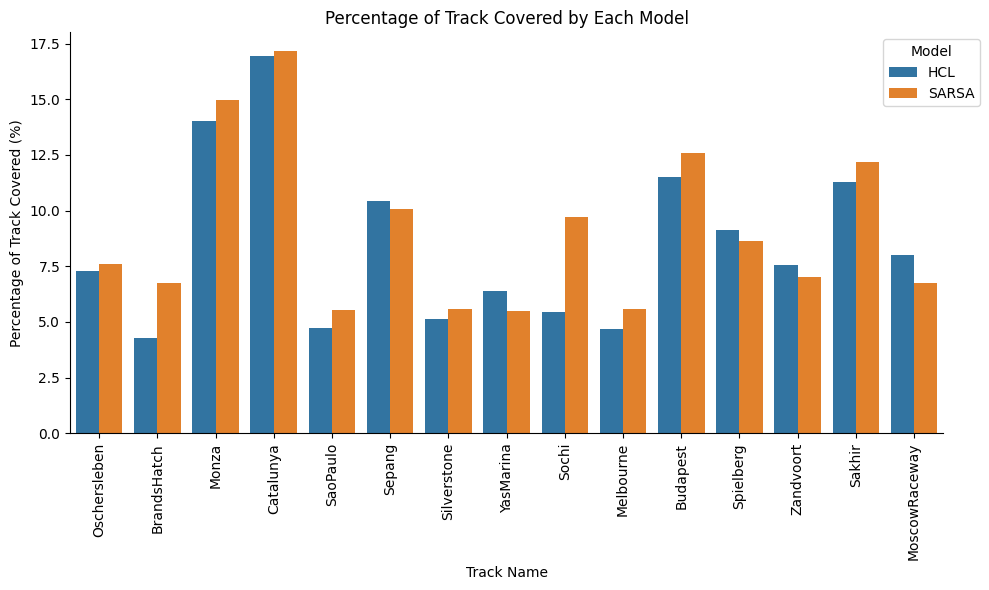

In [12]:
fig = sns.catplot(kind='bar', x='track_name', y='percentage_covered', hue='model', data=combined_df,height=6, aspect=1.5)
fig.set_xticklabels(rotation=90)
fig._legend.remove()
plt.title('Percentage of Track Covered by Each Model')
plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.05, 1))
plt.xlabel('Track Name')
plt.ylabel('Percentage of Track Covered (%)')
plt.tight_layout()

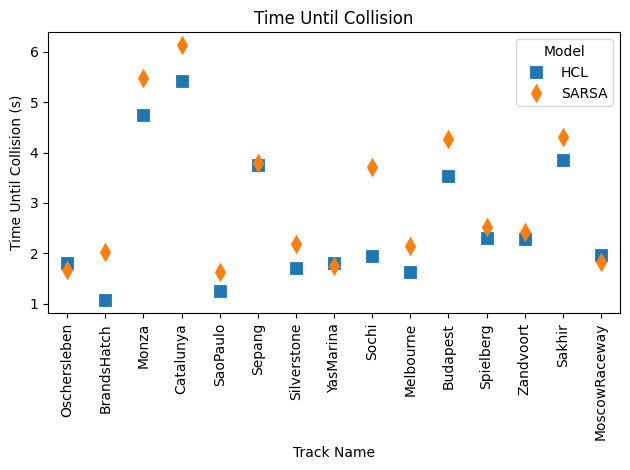

In [13]:
sns.pointplot( x='track_name', y='time_until_collision', hue='model', data=combined_df,markers=['s','d'],linestyles='')
# fig.set_xticklabels(rotation=90)
# fig._legend.remove()
plt.title('Time Until Collision')
plt.legend(title='Model', loc='upper right')
plt.xlabel('Track Name')
plt.xticks(rotation=90)
plt.ylabel('Time Until Collision (s)')
plt.tight_layout()